In [1]:
from warehouse_model.layout import Layout
from pulp import *
import numpy as np
import random
from math import ceil
from copy import deepcopy
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt 
import networkx as nx
import pickle
import os
from solver.slap_models import SLAP, SLAP_PA, SLAP_QA
import solver.ga as ga
from warehouse_model.graph_tools import viz_graph

In [2]:
def render_warehouse(warehouse: Layout, assignment, product_frequency):
    storage_assignment = deepcopy(warehouse.layout_grid)
    walkable_locs = np.where(warehouse.layout_grid == 0)

    for x, y, z in zip(walkable_locs[0], walkable_locs[1], walkable_locs[2]):
        storage_assignment[x,y,z] = -100

    for i, loc in enumerate(assignment):
        storage_assignment[warehouse.nodes_list[loc]] = i 

    storage_frequence = deepcopy(warehouse.layout_grid)
    for i, loc in enumerate(assignment):
        storage_frequence[warehouse.nodes_list[loc]] = product_frequency[i]
    
    node_xyz = np.array([warehouse.pos_dict[v] for v in sorted(warehouse.graph)])
    edge_xyz = np.array([(warehouse.pos_dict[u], warehouse.pos_dict[v]) for u, v in warehouse.graph.edges()])

    data = []
    for x, y, z in zip(node_xyz.T[0], node_xyz.T[1], node_xyz.T[2]):
        data_point = storage_frequence[x,y,z]
        data.append(data_point)

    assignment_plt = []
    for x, y, z in zip(node_xyz.T[0], node_xyz.T[1], node_xyz.T[2]):
        assignment_point = storage_assignment[x,y,z]
        assignment_plt.append(assignment_point)

    trace = go.Scatter3d(customdata=np.stack((data,assignment_plt),axis=-1), hovertemplate = 'x: %{x}<br>y: %{y}<br>z: %{z}<br>Order Frequency: %{customdata[0]}<br>Product: %{customdata[1]}}',
        x = node_xyz.T[0], y = node_xyz.T[1], z = node_xyz.T[2],mode = 'markers', marker = dict(symbol="square",
            size = 12,
            color = data, # set color to an array/list of desired values
            colorscale = 'thermal')
        )
    layout = go.Layout(title = 'Warehouse Visualization')
    fig = go.Figure(data = [trace], layout = layout)
    fig.update_traces(marker_size = 5)
    return fig

In [3]:
x = 3
z = 1
n_products = 14 
storage_per_aisle = x 
y = ceil(n_products / storage_per_aisle / z) * 2

In [55]:
warehouse = Layout(5, 3, 1, False, False, None) # two rows reserved for walking
double_deep = "False"
path = os.path.join("data/cache/dist_mats/", "dist_mat_" + str(warehouse.layout_grid.shape) + "_" + str(double_deep) + ".npy")
if os.path.exists(path):
    dist_mat = np.load(path)
else:
    dist_mat = warehouse.gen_dist_mat(path)

In [56]:
warehouse_heatmap = px.imshow(warehouse.layout_grid[:,:,0])

In [57]:
warehouse_heatmap.write_json("render/warehouse_heatmap.json")

In [47]:
size = len(warehouse.storage_locs)
product_pairs_frequency = np.zeros((size, size))
upper_bound = 9
for i in range(size):
    for j in range(size):
        if i == j: 
            product_pairs_frequency[i][j] = 0
        # since problem is a one-one problem, mapping (1,2) == (2,1) so there's no need to create duplicate mappings
        #if (j,i) in product_pairs_frequency: continue
        else:
            product_pairs_frequency[i][j] = random.randrange(0, upper_bound)

In [48]:
product_frequency = {}
for i in range(size):
    product_frequency[i] = product_pairs_frequency[i].sum()

In [49]:
n_storage_locs = len(warehouse.storage_locs)
#n_products = len(warehouse.storage_locs)
n_products = len(product_frequency.keys())

storage_locs = [warehouse.nodes_list.index(loc) for loc in warehouse.storage_locs]
products = [p for p in range(n_products)]
storage_loc_mapping = {i:loc for i,loc in enumerate(storage_locs)}
storage_locs_new = [i for i in storage_loc_mapping.keys()]
depot = 0

In [50]:
assignment = storage_locs

In [51]:
product_frequency

{0: 40.0,
 1: 73.0,
 2: 54.0,
 3: 50.0,
 4: 64.0,
 5: 56.0,
 6: 83.0,
 7: 66.0,
 8: 55.0,
 9: 60.0,
 10: 53.0,
 11: 41.0,
 12: 61.0,
 13: 45.0,
 14: 63.0}

In [39]:
fig = render_warehouse(warehouse, assignment, product_frequency)

In [40]:
fig.show()

In [41]:
fig.write_json("render/warehouse_3d.json")

Text(0.5, 0, 'z-axis')

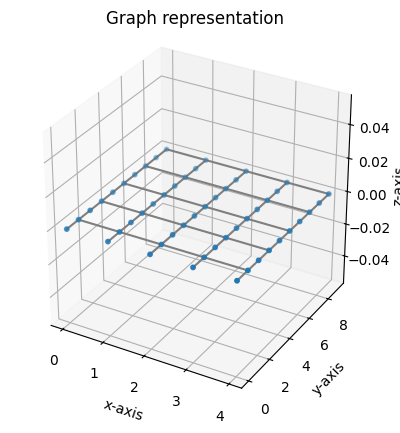

In [54]:
node_xyz = np.array([warehouse.pos_dict[v] for v in sorted(warehouse.graph)])
edge_xyz = np.array([(warehouse.pos_dict[u], warehouse.pos_dict[v]) for u, v in warehouse.graph.edges()])
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

#plot nodes
ax.scatter(node_xyz.T[0], node_xyz.T[1], node_xyz.T[2], s=10)

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

ax.set_box_aspect([1,1,1])
ax.set_title("Graph representation")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

In [14]:
dist_mat_storage = dist_mat[storage_locs][:, storage_locs]

In [17]:
products = [0, 1, 2, 3]
storage_locs = [0, 1, 2, 3]
w = np.array([[0,3,0,2], 
     [3,0,0,1], #Flow matrix (between assignees)
     [0,0,0,4],
     [2,1,4,0]])

d = np.array([[0,22,53,53],
     [22,0,40,62], #Distance matrix (between assignments)
     [53,40,0,55],
     [53,62,55,0]])

slap = SLAP_QA(d, products, w, storage_locs, depot)

In [18]:
slap.report()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-22
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.6.0 21G816)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 8 rows, 16 columns and 32 nonzeros
Model fingerprint: 0x93cffeac
Model has 48 quadratic objective terms
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]


Found heuristic solution: objective 1022.0000000
Presolve time: 0.01s
Presolved: 56 rows, 64 columns, 176 nonzeros
Variable types: 0 continuous, 64 integer (64 binary)

Root relaxation: objective 0.000000e+00, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    8 1022.00000    0.00000   100%     -    0s
H    0     0                     824.0000000    0.00000   100%     -    0s
     0     0    0.00000    0    8  824.00000    0.00000   100%     -    0s
     0     0  324.00000    0   14  824.00000  324.00000  60.7%     -    0s
H    0     0                     790.0000000  324.00000  59.0%     -    0s
     0     0  424.80000    0   26  790.00000  424.80000  46.2%     -    0s
     0     0  425.50000    0   23  790.00000  425.50000  46.1%     -    0s
     0     0  740.00000    0   16  790.00000  740.00000  6.33%     

In [28]:
slap = SLAP(dist_mat, products, product_frequency, storage_locs, depot)

In [29]:
slap.report() 

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-22
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.6.0 21G816)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 30 rows, 225 columns and 450 nonzeros
Model fingerprint: 0xc0bf4ee5
Variable types: 0 continuous, 225 integer (225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5799.0000000
Presolve time: 0.00s
Presolved: 30 rows, 225 columns, 450 nonzeros
Variable types: 0 continuous, 225 integer (225 binary)

Root relaxation: objective 5.372000e+03, 90 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd 

In [30]:
slap = SLAP_PA(dist_mat, products, product_frequency, product_pairs_frequency, storage_locs, depot)

In [31]:
slap.report()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.6.0 21G816)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 30 rows, 225 columns and 450 nonzeros
Model fingerprint: 0x99d4f748
Model has 22050 quadratic objective terms
Variable types: 0 continuous, 225 integer (225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 8e+02]
  QObjective range [4e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 10044.000000
Presolve time: 0.32s
Presolved: 30 rows, 225 columns, 450 nonzeros
Presolved model has 22275 quadratic objective terms
Variable types: 0 continuous, 225 integer (225 binary)

Root relaxation: objective -1.360954e+04, 256 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  O

In [ ]:
fig_new = render_warehouse(warehouse, [11, 12, 6, 9, 8, 5], product_frequency)

In [ ]:
fig_new.show()

In [ ]:
#fig_new.write_json("new_layout.json") 

In [20]:
def generate_genome(products, locations_list):
    chromosome = []
   
    random.shuffle(locations_list)
    for i in range(len(products)):
        storage_loc = locations_list[i]
        chromosome.append(storage_loc)
    return chromosome

In [21]:
initial_population = [generate_genome(products, storage_locs) for _ in range(200)]

In [23]:
fitness_tracker = []
min_fitness = np.inf
for g in range(5000):
    new_pop = []
    pop_results = []
    
   
    fitness_result = [ga.fitness_qa(pop, d, w) for pop in initial_population]
    print(g, min(fitness_result))
    fitness_tracker.append(min(fitness_result))
    for _ in range(100):
        selected = ga.selection(initial_population, fitness_result)
        child = ga.crossover(selected)
        mutated = ga.mutation(child)
        new_pop.append(mutated)
    initial_population = new_pop

min_fitness = min(fitness_result)
min_child = initial_population[fitness_result.index(min_fitness)]

0 790
1 834
2 790
3 834
4 790
5 834
6 790
7 834
8 790
9 834
10 790
11 834
12 790
13 834
14 790
15 834
16 790
17 834
18 790
19 834
20 790
21 834
22 790
23 834
24 790
25 834
26 790
27 834
28 790
29 834
30 790
31 834
32 790
33 834
34 790
35 834
36 790
37 834
38 790
39 834
40 790
41 834
42 790
43 834
44 790
45 834
46 790
47 834
48 790
49 834
50 790
51 834
52 790
53 834
54 790
55 834
56 790
57 834
58 790
59 834
60 790
61 834
62 790
63 834
64 790
65 834
66 790
67 834
68 790
69 834
70 790
71 834
72 790
73 834
74 790
75 834
76 790
77 834
78 790
79 834
80 790
81 834
82 790
83 834
84 790
85 834
86 790
87 834
88 790
89 834
90 790
91 834
92 790
93 834
94 790
95 834
96 790
97 834
98 790
99 834
100 790
101 834
102 790
103 834
104 790
105 834
106 790
107 834
108 790
109 834
110 790
111 834
112 790
113 834
114 790
115 834
116 790
117 834
118 790
119 834
120 790
121 834
122 790
123 834
124 790
125 834
126 790
127 834
128 790
129 834
130 790
131 834
132 790
133 834
134 790
135 834
136 790
137 834
138 79

In [ ]:
# initial_population = [ga.generate_genome(products, warehouse) for i in range(1000)]

    
#product_pairs_frequency = calc_product_affinity(orders)
# product_frequency_pf_pa = [0 for i in range(len(product_frequency.keys()))]
# for i in list(product_frequency.values()):
product_frequency_pf_pa = list(product_frequency.values())



# product_pairs_np = np.zeros((n_products, n_products))
# for key in product_pairs_frequency.keys():
#     for pair in product_pairs_frequency[key].keys():
#         product_pairs_np[key][pair] = product_pairs_frequency[key][pair]

fitness_tracker = []
min_fitness = np.inf
for g in range(500):
    new_pop = []
    pop_results = []
    
   
    fitness_result = [ga.fitness_pf_pa(pop, dist_mat, product_frequency_pf_pa, product_pairs_frequency) for pop in initial_population]
    print(g, min(fitness_result))
    fitness_tracker.append(min(fitness_result))
    for _ in range(100):
        selected = ga.selection(initial_population, fitness_result)
        child = ga.crossover(selected)
        mutated = ga.mutation(child)
        new_pop.append(mutated)
    initial_population = new_pop

min_fitness = min(fitness_result)
min_child = initial_population[fitness_result.index(min_fitness)]

0 735.0
1 735.0
2 735.0
3 735.0
4 735.0
5 735.0
6 735.0
7 735.0
8 735.0
9 735.0
10 735.0
11 735.0
12 735.0
13 735.0
14 735.0
15 735.0
16 735.0
17 735.0
18 735.0
19 735.0
20 735.0
21 735.0
22 735.0
23 735.0
24 735.0
25 735.0
26 735.0
27 735.0
28 735.0
29 735.0
30 735.0
31 735.0
32 735.0
33 735.0
34 735.0
35 735.0
36 735.0
37 735.0
38 735.0
39 735.0
40 735.0
41 735.0
42 735.0
43 735.0
44 735.0
45 735.0
46 735.0
47 735.0
48 735.0
49 735.0
50 735.0
51 735.0
52 735.0
53 735.0
54 735.0
55 735.0
56 735.0
57 735.0
58 735.0
59 735.0
60 735.0
61 735.0
62 735.0
63 735.0
64 735.0
65 735.0
66 735.0
67 735.0
68 735.0
69 735.0
70 735.0
71 735.0
72 735.0
73 735.0
74 735.0
75 735.0
76 735.0
77 735.0
78 735.0
79 735.0
80 735.0
81 735.0
82 735.0
83 735.0
84 735.0
85 735.0
86 735.0
87 735.0
88 735.0
89 735.0
90 735.0
91 735.0
92 735.0
93 735.0
94 735.0
95 735.0
96 735.0
97 735.0
98 735.0
99 735.0
100 735.0
101 735.0
102 735.0
103 735.0
104 735.0
105 735.0
106 735.0
107 735.0
108 735.0
109 735.0
110 735.0
